In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("behrad3d/nasa-cmaps")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/behrad3d/nasa-cmaps/versions/1


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression, RFECV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [13]:
train_data = pd.read_csv('~/.cache/kagglehub/datasets/behrad3d/nasa-cmaps/versions/1/CMaps/train_FD001.txt', sep=" ", header=None)
test_data = pd.read_csv('~/.cache/kagglehub/datasets/behrad3d/nasa-cmaps/versions/1/CMaps/test_FD001.txt', sep=" ", header=None)
test_rul = pd.read_csv('~/.cache/kagglehub/datasets/behrad3d/nasa-cmaps/versions/1/CMaps/RUL_FD001.txt', sep=" ", header=None)

# Drop the extra columns (they are all NaNs)
train_data.drop(columns=[26, 27], inplace=True)
test_data.drop(columns=[26, 27], inplace=True)
test_rul.drop(columns=[1], inplace=True)

# Add column names
columns = ['unit_number', 'time_in_cycles'] + [f'sensor_{i}' for i in range(1, 22)] + ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']
train_data.columns = columns
test_data.columns = columns
test_rul.columns = ['RUL']

In [14]:
train_data.head()

,unit_number,time_in_cycles,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,operational_setting_1,operational_setting_2,operational_setting_3
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [15]:
test_data.head()

,unit_number,time_in_cycles,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,operational_setting_1,operational_setting_2,operational_setting_3
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            13096 non-null  int64  
 1   time_in_cycles         13096 non-null  int64  
 2   sensor_1               13096 non-null  float64
 3   sensor_2               13096 non-null  float64
 4   sensor_3               13096 non-null  float64
 5   sensor_4               13096 non-null  float64
 6   sensor_5               13096 non-null  float64
 7   sensor_6               13096 non-null  float64
 8   sensor_7               13096 non-null  float64
 9   sensor_8               13096 non-null  float64
 10  sensor_9               13096 non-null  float64
 11  sensor_10              13096 non-null  float64
 12  sensor_11              13096 non-null  float64
 13  sensor_12              13096 non-null  float64
 14  sensor_13              13096 non-null  float64
 15  se

In [20]:
test_rul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   RUL     100 non-null    int64
dtypes: int64(1)
memory usage: 932.0 bytes


In [17]:
from sklearn.model_selection import train_test_split

In [23]:
df_elements = pd.read_excel('/content/Elements_dataset  (1).xlsx')

In [25]:
df_elements.head(20)

,weight,category,letter,clarity,quality,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [35]:
df_elements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight    50000 non-null  float64
 1   category  50000 non-null  object 
 2   letter    50000 non-null  object 
 3   clarity   50000 non-null  object 
 4   quality   50000 non-null  float64
 5   table     50000 non-null  float64
 6   price     50000 non-null  int64  
 7   x         50000 non-null  float64
 8   y         50000 non-null  float64
 9   z         50000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


In [36]:
df_elements.drop_duplicates()

,weight,category,letter,clarity,quality,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
49995,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
49996,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
49997,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
49998,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [37]:
df_elements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight    50000 non-null  float64
 1   category  50000 non-null  object 
 2   letter    50000 non-null  object 
 3   clarity   50000 non-null  object 
 4   quality   50000 non-null  float64
 5   table     50000 non-null  float64
 6   price     50000 non-null  int64  
 7   x         50000 non-null  float64
 8   y         50000 non-null  float64
 9   z         50000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


In [38]:
df_elements.isnull().sum()

,0
weight,0
category,0
letter,0
clarity,0
quality,0
table,0
price,0
x,0
y,0
z,0


In [40]:
df_elements.describe()

,weight,quality,table,price,x,y,z
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.799444,61.753006,57.457830,3944.805440,5.734403,5.737956,3.541056
std,0.475173,1.431088,2.232092,3997.938105,1.123077,1.145579,0.707065
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2410.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5351.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [41]:
categorical_features = df_elements.select_dtypes(include=["object"])
categorical_features.columns

Index(['category', 'letter', 'clarity'], dtype='object')

In [43]:
numeric_features = df_elements.select_dtypes(include=["number"])
numeric_features.columns

Index(['weight', 'quality', 'table', 'price', 'x', 'y', 'z'], dtype='object')

In [45]:
corr_matrix = numeric_features.corr()
corr_matrix["price"].sort_values(ascending=False)

,price
price,1.000000
weight,0.921804
x,0.884919
y,0.864393
z,0.860963
table,0.129848
quality,-0.012731


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [47]:
# Initialize LabelEncoder
le = LabelEncoder()
df_elements['category'] = le.fit_transform(df_elements['category'])
df_elements['letter'] = le.fit_transform(df_elements['letter'])
df_elements['clarity'] = le.fit_transform(df_elements['clarity'])
df_elements.head()

,weight,category,letter,clarity,quality,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [48]:
def log_transform(df_elements, column):
    df_elements[column] = np.log1p(df_elements[column])  # log1p(x) is equivalent to log(1 + x), it helps avoid log(0)
    return df_elements

for col in df_elements.columns:
    df_elements = log_transform(df_elements, col)


In [50]:
df_elements.head(20)

,weight,category,letter,clarity,quality,table,price,x,y,z
0,0.207014,1.098612,0.693147,1.386294,4.135167,4.025352,5.789960,1.599388,1.605430,1.232560
1,0.190620,1.386294,0.693147,1.098612,4.107590,4.127134,5.789960,1.587192,1.576915,1.196948
2,0.207014,0.693147,0.693147,1.609438,4.058717,4.189655,5.793014,1.619388,1.623341,1.196948
3,0.254642,1.386294,1.791759,1.791759,4.149464,4.077537,5.814131,1.648659,1.654411,1.289233
4,0.270027,0.693147,1.945910,1.386294,4.163560,4.077537,5.817111,1.675226,1.677097,1.321756
5,0.215111,1.609438,1.945910,2.079442,4.155753,4.060443,5.820083,1.597365,1.601406,1.247032
6,0.215111,1.609438,1.791759,1.945910,4.147885,4.060443,5.820083,1.599388,1.605430,1.244155
7,0.231112,1.609438,1.609438,1.098612,4.141546,4.025352,5.823046,1.623341,1.631199,1.261298
8,0.198851,0.000000,0.693147,1.791759,4.191169,4.127134,5.823046,1.583094,1.564441,1.249902
9,0.207014,1.609438,1.609438,1.609438,4.100989,4.127134,5.826000,1.609438,1.619388,1.220830


In [51]:
X = df_elements.drop(columns='price')
Y = df_elements['price']

In [52]:
X.head()

,weight,category,letter,clarity,quality,table,x,y,z
0,0.207014,1.098612,0.693147,1.386294,4.135167,4.025352,1.599388,1.605430,1.232560
1,0.190620,1.386294,0.693147,1.098612,4.107590,4.127134,1.587192,1.576915,1.196948
2,0.207014,0.693147,0.693147,1.609438,4.058717,4.189655,1.619388,1.623341,1.196948
3,0.254642,1.386294,1.791759,1.791759,4.149464,4.077537,1.648659,1.654411,1.289233
4,0.270027,0.693147,1.945910,1.386294,4.163560,4.077537,1.675226,1.677097,1.321756


In [53]:
Y.head()

,price
0,5.789960
1,5.789960
2,5.793014
3,5.814131
4,5.817111


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [55]:
X_train.shape

(40000, 9)

In [56]:
y_train.shape

(40000,)

In [61]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [63]:
fsf_selector = SelectKBest(score_func=f_classif, k=5)  # Select top 5 features
X_new_fsf = fsf_selector.fit_transform(X, Y)
selected_fsf_features = X.columns[fsf_selector.get_support()]

lin_reg = LinearRegression()
rfe_selector = RFE(lin_reg, n_features_to_select=5)  # Select top 5 features
rfe_selector.fit(X, Y)
selected_rfe_features = X.columns[rfe_selector.support_]

# Results
print("Forward Feature Selection Features:", selected_fsf_features.tolist())
print("Recursive Feature Elimination Features:", selected_rfe_features.tolist())

Forward Feature Selection Features: ['weight', 'letter', 'x', 'y', 'z']
Recursive Feature Elimination Features: ['weight', 'table', 'x', 'y', 'z']


In [67]:
lin_reg.fit(X_train,y_train)
pred = lin_reg.predict(X_test)
df_results = pd.DataFrame({'Actual': y_test, 'Predicted':pred})

df_results['REs'] = abs(df_results['Actual']) - abs(df_results['Predicted'])


In [68]:
df_results.head()

,Actual,Predicted,REs
33553,6.837333,7.101687,-0.264354
9427,8.464847,8.128816,0.336031
199,7.930925,7.754300,0.176625
12447,8.618305,8.647917,-0.029612
39489,6.226537,6.536531,-0.309994


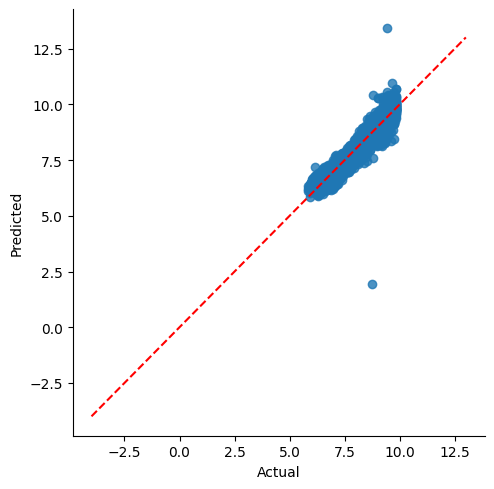

In [70]:
import seaborn
sns.lmplot(x='Actual', y='Predicted', data= df_results, fit_reg= False)

line_coords = np.arange(df_results.min().min(), df_results.max().max())
plt.plot(line_coords, line_coords, color='red', linestyle ='--', )
plt.show()

In [72]:
feature_data_with_constant = sm.add_constant(X)

# Implement Backward Elimination Feature Selection
def backward_elimination(X, Y, significance_level=0.05):
    while True:
        model = sm.OLS(Y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()

        if max_p_value > significance_level:
            feature_to_remove = p_values.idxmax()
            X = X.drop(columns=[feature_to_remove])
        else:
            break
    return model, X

# Run Backward Elimination
final_model, selected_features = backward_elimination(feature_data_with_constant, Y)

# Summary of the final model
print(final_model.summary())

# Display final selected features
print("\nFinal selected features:", selected_features.columns.tolist())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 9.987e+04
Date:                Thu, 06 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:04:45   Log-Likelihood:                -891.99
No. Observations:               50000   AIC:                             1802.
Df Residuals:                   49991   BIC:                             1881.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0088      0.132     22.854      0.0

ASSU1

KeyboardInterrupt: 

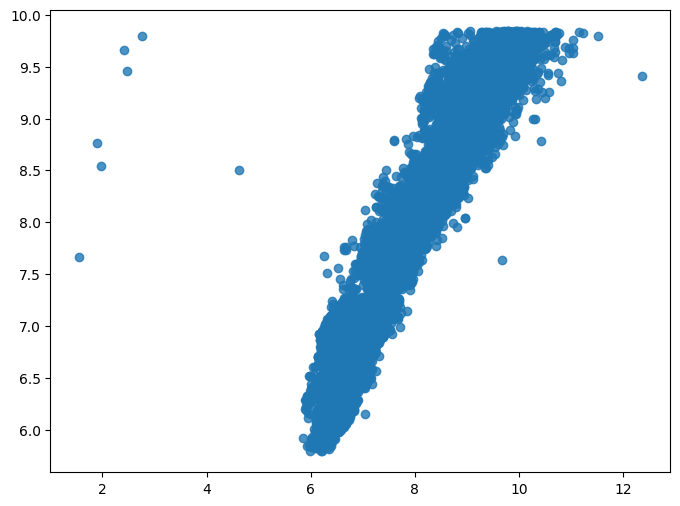

In [77]:
plt.figure(figsize=(8, 6))
sns.regplot(x=final_model.fittedvalues, y=Y, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted Values")
plt.ylabel("Actual Price")
plt.title("Linearity Check: Fitted vs. Actual")
plt.show()

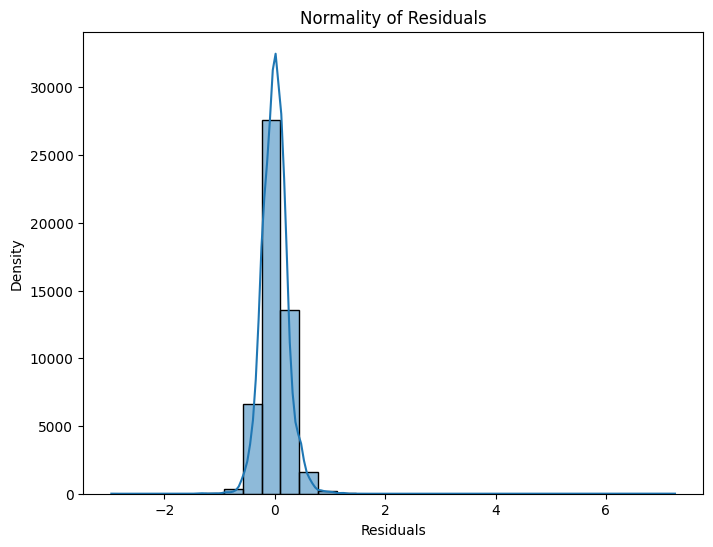

In [75]:
 #Normality of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(final_model.resid, kde=True, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Normality of Residuals")
plt.show()

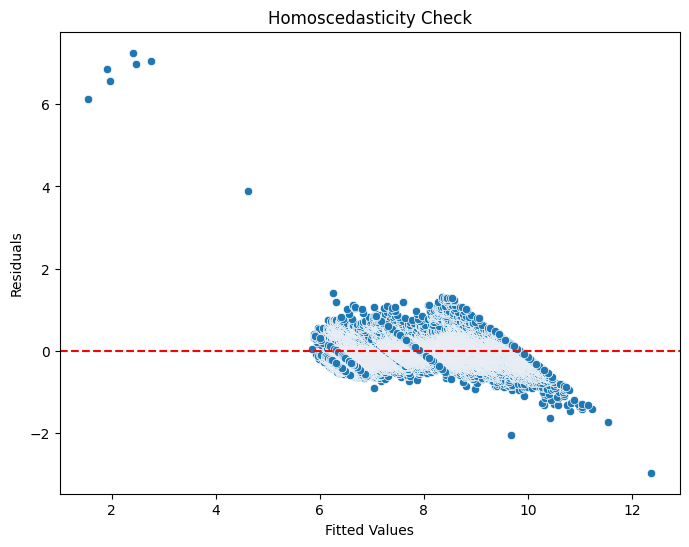

In [78]:
#Homoscedasticity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=final_model.fittedvalues, y=final_model.resid)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Homoscedasticity Check")
plt.show()

In [81]:
feature_data_with_const = sm.add_constant(X)
new_model = sm.OLS(df_elements["price"], feature_data_with_const).fit()
feature_names = list(new_model.params.index)

p_values = new_model.pvalues
z_scores = new_model.tvalues

feature_importance = pd.DataFrame({"Feature": feature_names, "Z-score": z_scores, "P-value": p_values})
feature_importance = feature_importance.sort_values(by="P-value")

print("\nFeature Significance:")
print(feature_importance)


Feature Significance:
           Feature    Z-score        P-value
weight      weight  88.850218   0.000000e+00
letter      letter -86.581140   0.000000e+00
clarity    clarity  89.914426   0.000000e+00
x                x  23.150560  6.006155e-118
table        table -20.763653   2.335348e-95
y                y  19.095226   5.381306e-81
category  category   9.163235   5.221345e-20
const        const   8.374605   5.682735e-17
z                z   7.419138   1.197486e-13
quality    quality   0.731213   4.646524e-01


In [84]:
selected_features = feature_importance[feature_importance["P-value"] < 0.005]["Feature"].tolist()

print("\nSelected Features:")
print(selected_features)



Selected Features:
['weight', 'letter', 'clarity', 'x', 'table', 'y', 'category', 'const', 'z']
